# Compression & Entropy

In [1]:
# Load Python libraries
import numpy as np
from collections import Counter
from scipy.stats import entropy

In [2]:
# Load Plot libraries
import seaborn as sns
import matplotlib.pyplot as plt

### Huffman Code class

In [3]:
# Class HuffmanCode from scratch
class HuffmanCode:
    
    # Return a Huffman code for an ensemble with distribution p
    def get_code(self, p_symbols):
        
        # Init validation
        n = len(p_symbols)
        if n == 0:
            return dict()
        elif n == 1:
            return dict(zip(p_symbols.keys(), ['1']))
        
        # Ensure probabilities sum to 1
        self._normalize_weights(p_symbols)
        
        # Returns Huffman code
        return self._get_code(p_symbols);
    
    # (Private) Calculate Huffman code
    def _get_code(self, p):
        
        # Base case of only two symbols, assign 0 or 1 arbitrarily
        if len(p) == 2:
            return dict(zip(p.keys(), ['0', '1']))
        
        # Create a new distribution by merging lowest prob pair
        p_prime = p.copy()
        s1, s2 = self._get_lowest_prob_pair(p)
        p1, p2 = p_prime.pop(s1), p_prime.pop(s2)
        p_prime[s1 + s2] = p1 + p2
        
        # Recurse and construct code on new distribution
        code = self._get_code(p_prime)
        symbol = s1 + s2
        s1s2 = code.pop(symbol)
        code[s1], code[s2] = s1s2 + '0', s1s2 + '1'
        
        return code;
    
    # Return pair of symbols from distribution p with lowest probabilities
    def _get_lowest_prob_pair(self, p):
        
        # Ensure there are at least 2 symbols in the dist.
        if len(p) >= 2:
            sorted_p = sorted(p.items(), key=lambda x: x[1])
            return sorted_p[0][0], sorted_p[1][0];
        
        return (None, None);
    
    # Makes sure all weights add up to 1
    def _normalize_weights(self, p_symbols, t_weight=1.0):
        n = sum(p_symbols.values())
        
        if n != t_weight:
            for s in p_symbols:
                p_symbols[s] = p_symbols[s] / n;

In [4]:
# Create Huffman Code instance
hc = HuffmanCode()

## 1. Compression with current Entropy

In [5]:
# Function - Read file in low level (Bytes)
def get_file_bytes(file_path):
    with open(file_path, 'rb') as f:
        return bytearray(f.read());
    return None;

In [6]:
# Function - Return shannon entropy
def entropy_shannon(labels, base=None):
    value, counts = np.unique(labels, return_counts=True)
    return entropy(counts, base=base)

In [7]:
# Loading target image
file_path = "../data/text/book-1.txt"
text_byte_list = get_file_bytes(file_path)
print(len(text_byte_list), 'Bytes')

1257099 Bytes


### Theoretical compression percentage

In [8]:
# Function - Calculates the compression percentage (%)
def calc_compression_percentage(curr_size, new_size):
    return round((curr_size - new_size) / curr_size * 100, 2);

In [9]:
# Calculate entropy of image
curr_entropy = entropy_shannon(text_byte_list, 2)
curr_entropy

4.59266006221856

In [10]:
# Real compression percentage (%)
curr_size = 8
new_size = curr_entropy
compress_rate = calc_compression_percentage(curr_size, new_size)
print(compress_rate, '%')

42.59 %


### Real compression percentage

In [11]:
# Function - Calculate code frequency
def get_term_freq(term_list):
    term_freq = {}
    terms_count = dict(Counter(term_list))
    
    for key, value in terms_count.items():
        if isinstance(key, int):
            key = chr(key)
        term_freq[key] = value
    
    return term_freq;

# Function - Build the compress file
def create_compress_file(byte_list, code_list):
    compress_list = []
    
    for symbol in byte_list:
        key = chr(symbol)
        new_symbol = code_list[key]
        compress_list.append(new_symbol)
    
    # Return compress file
    return "".join(compress_list)

# Function - Compressing file
def get_compress_file(byte_list):
    
    # Get symbols frequency
    term_freq = get_term_freq(byte_list)
    
    # Normalize term frequency
    n = sum(term_freq.values())
    for term in term_freq:
        term_freq[term] = term_freq[term] / n;
    
    # Get Huffman coding
    h_code = hc.get_code(term_freq)
    
    # Compressing file with Huffman code
    compress_file = create_compress_file(byte_list, h_code)
            
    return compress_file, h_code;

In [12]:
# Compressing initial text file
compress_file, h_code = get_compress_file(text_byte_list)

In [13]:
# Real compression percentage (%)
curr_size = len(text_byte_list)
new_size = len(compress_file) / 8
compress_rate = calc_compression_percentage(curr_size, new_size)
print(compress_rate, '%')

42.19 %


## 2. Compression changing Entropy

In [14]:
# Function - Find the low entropy setup for target file
def find_low_entropy(byte_list):
    best_byte_list = []
    best_entropy = 8
    best_key = -1
    
    for curr_key in range(256):
        curr_byte_list = [(byte ^ curr_key) for byte in byte_list]
        curr_entropy = entropy_shannon(curr_byte_list, 2)
        
        if curr_entropy < best_entropy:
            print('curr_entropy:',curr_entropy, ', best_entropy:', best_entropy, ', curr_key:', curr_key)
            best_entropy = curr_entropy
            best_key = curr_key
            best_byte_list = curr_byte_list.copy()
    
    return best_byte_list, best_entropy, best_key

In [15]:
# Find file with low entropy
best_byte_list, best_entropy, best_key = find_low_entropy(text_byte_list)

curr_entropy: 4.59266006221856 , best_entropy: 8 , curr_key: 0
curr_entropy: 4.592660062218559 , best_entropy: 4.59266006221856 , curr_key: 33


In [16]:
# Show best entropy setup
best_entropy

4.592660062218559

In [17]:
# Save the new file as txt
file_path = file_path.replace('.txt', '-new.txt')
with open(file_path, 'w+b') as f:
    binary_format = bytearray(best_byte_list)
    f.write(binary_format)

In [18]:
# Function - Create byte matrix
def create_byte_matrix(byte_list, row_len, col_len):
    matrix = np.zeros((row_len, col_len))
    data = np.array(byte_list)
    
    # Save bytes into matrix
    for i in range(0, len(data)):
        ix_row = int(i / col_len)
        ix_col = i % col_len
        matrix[ix_row][ix_col] = data[i]
    
    return matrix;

In [19]:
# Function - Plot image in binary file
def plot_byte_metrix(matrix, plt_title):
    fig, ax = plt.subplots(figsize = (14, 14))
    sns.heatmap(matrix, ax = ax)
    ax.set_title(plt_title, fontsize = 16)
    ax.set_xlabel('columns', fontsize = 12)
    ax.set_ylabel('rows', fontsize = 12)
    plt.show()

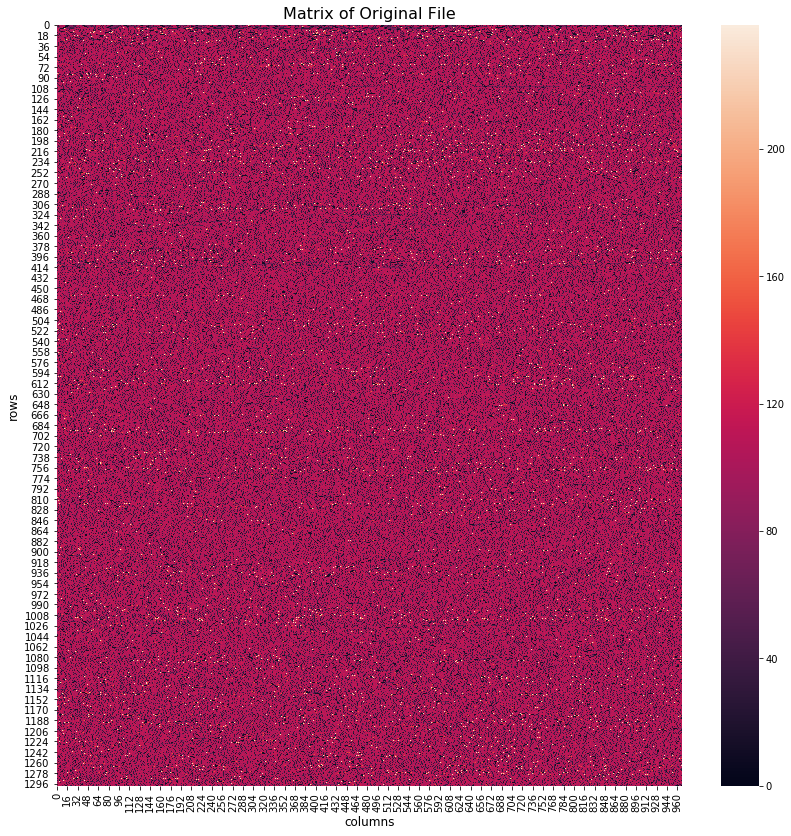

In [20]:
# Create and plot original matrix
row_len = 1300
col_len = 967
ori_matrix = create_byte_matrix(text_byte_list, row_len, col_len)
plot_byte_metrix(ori_matrix, 'Matrix of Original File')

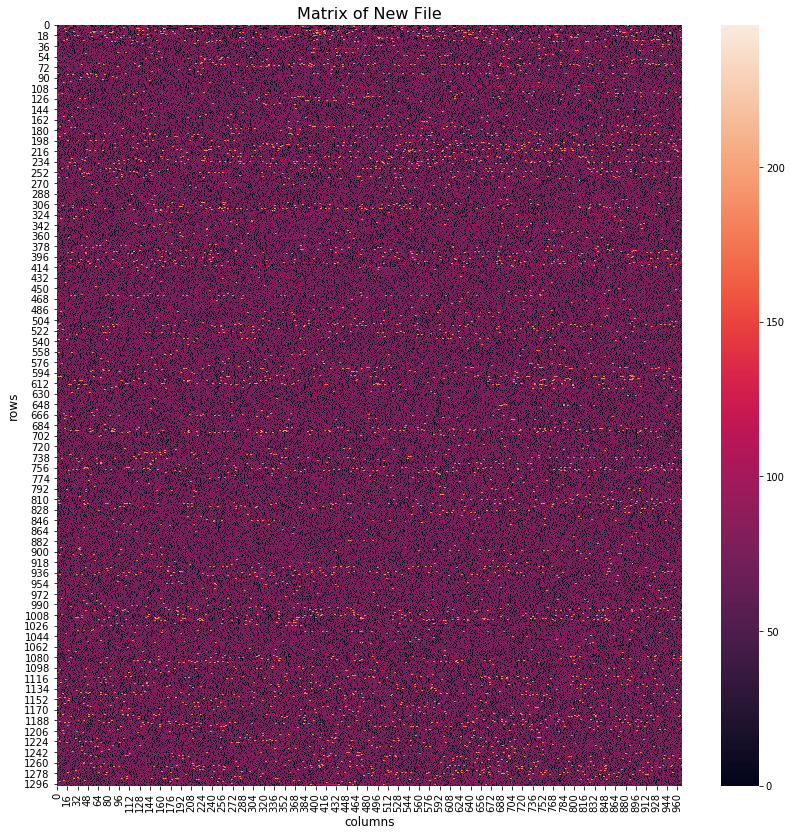

In [21]:
# Create and plot the new matrix (with low entropy)
row_len = 1300
col_len = 967
ori_matrix = create_byte_matrix(best_byte_list, row_len, col_len)
plot_byte_metrix(ori_matrix, 'Matrix of New File')

<hr>
<p><a href="https://ansegura7.github.io/DataCompression/">« Home</a></p>